<a href="https://colab.research.google.com/github/Priyo-prog/Statistics-and-Data-Science/blob/main/Outliers/dealing_with_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Outliers**

Sometimes our dataset is not nice enough to simply have a NaN or Zero values to make it easy to tell what we should remove. Sometimes our dataset has outliers in it. So let's see some strategies to identifying these points.

## Import Libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

filename_1 = '/content/drive/MyDrive/Data Science/Statistical Analysis/outlier_1d.txt'
filename_2 = '/content/drive/MyDrive/Data Science/Statistical Analysis/outlier_2d.txt'
filename_3 = '/content/drive/MyDrive/Data Science/Statistical Analysis/outlier_curve.txt'

## Load the data

In [2]:
## mount the google drive to fetch the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(1010,) (1010, 2)


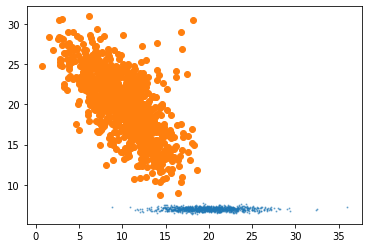

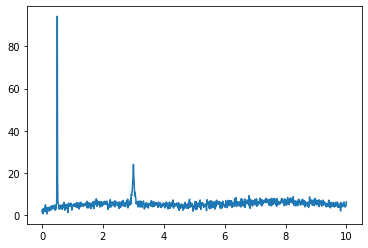

In [3]:
d1 = np.loadtxt(filename_1)
d2 = np.loadtxt(filename_2)
d3 = np.loadtxt(filename_3)
print(d1.shape, d2.shape)

plt.scatter(d1, np.random.normal(7, 0.2, size=d1.size), s=1, alpha=0.5)
plt.scatter(d2[:, 0], d2[:, 1])
plt.show()
plt.plot(d3[:, 0], d3[:, 1])

## **Basics**

The most basic and most common way of manually doing outlier pruning on data distributions is to :

1. Model your data at some alnalytical distribution

2. Find all points below a certain probability

3. Remove them

4. Refit the distributions, and potentially run again from Step 1

Rejection 5 points
z-score of 3 corresponds to a prob of 0.27%


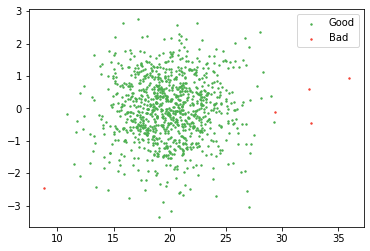

In [4]:
mean, std = np.mean(d1), np.std(d1)
z_score = np.abs((d1 - mean) / std)
threshold = 3
good = z_score < threshold

print(f"Rejection {(~good).sum()} points")
print(f"z-score of 3 corresponds to a prob of {100 * 2 * norm.sf(threshold):0.2f}%")
visual_scatter = np.random.normal(size=d1.size)
plt.scatter(d1[good], visual_scatter[good], s=2, label="Good", color='#4CAF50')
plt.scatter(d1[~good], visual_scatter[~good], s=2, label="Bad", color='#F44336')
plt.legend()

## Outliers for 2-d data

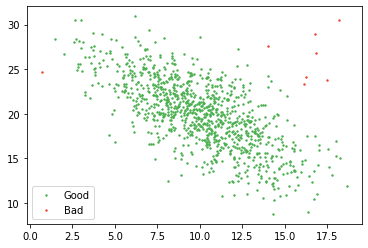

In [7]:
from scipy.stats import multivariate_normal as mn

mean, cov = np.mean(d2, axis=0), np.cov(d2.T)
good = mn(mean, cov).pdf(d2) > 0.01 / 100

plt.scatter(d2[good,0], d2[good,1], s=2, label="Good", color="#4CAF50")
plt.scatter(d2[~good,0], d2[~good,1], s=2, label="Bad", color="#F44336")
plt.legend()

## Using Polyfit

We can solve the outliers with polynomial fit but it is difficult if there is unnatural data spikes in it

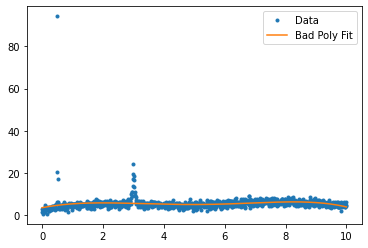

In [15]:
xs, ys = d3.T
p = np.polyfit(xs, ys, deg=5)
ps = np.polyval(p, xs)

plt.plot(xs, ys, ".", label="Data")
plt.plot(xs, ps, label="Bad Poly Fit")
plt.legend()

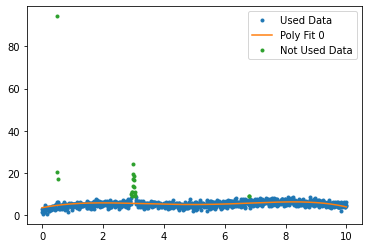

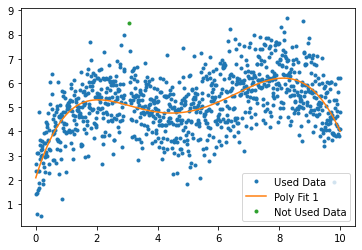

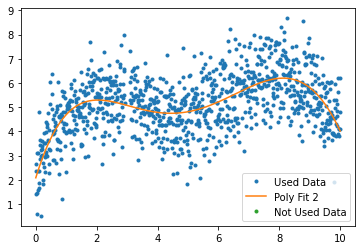

In [22]:
x, y = xs.copy(), ys.copy()

for i in range(5):
  p = np.polyfit(x,y, deg=5)
  ps = np.polyval(p,x)
  good = y - ps < 3 # only remove positive outliers

  x_bad, y_bad = x[~good], y[~good]
  x,y = x[good], y[good]

  plt.plot(x,y, ".", label="Used Data")
  plt.plot(x, np.polyval(p,x), label = f"Poly Fit {i}")
  plt.plot(x_bad, y_bad, ".", label="Not Used Data")
  plt.legend()
  plt.show()

  if(~good).sum() == 0:
    break

In the above code the first iteration of the loop, we are getting the polynomial fit of the ouliers data. In the 2nd iterartion we removed some outliers and few are still left **"good = y - ps < 3"** line does the job.
In the 3rd iteration we see all the outliers are removed and a nice fit is visible to us.